In [1]:
from snowflake import connector
import pathlib
from dotenv import dotenv_values
import pandas as pd
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Query connection

In [2]:
# Get the parent directory of the current working directory
script_path = pathlib.Path.cwd().parent
config = dotenv_values(f"{script_path}/configuration.env")

In [3]:
# Create the connection URL with proper formatting
connection_url = (
    f"snowflake://{config.get('snowflake_user')}:{config.get('snowflake_password')}@"
    f"{config.get('snowflake_account')}/"
    f"{config.get('snowflake_database')}/"
    f"{config.get('snowflake_schema')}?"
    f"warehouse={config.get('snowflake_warehouse')}&"
    f"role={config.get('snowflake_role')}"
)

# Create the SQLAlchemy engine with disable_ocsp_checks set to True
engine = create_engine(
    connection_url,
    connect_args={"disable_ocsp_checks": True}
)

In [4]:
# Load data with pandas
query = """
SELECT 
    f.review_text
    
FROM FCT_REVIEW f
"""
df = pd.read_sql(query, engine)

df.head()

,review_text
0,The British Airways plane I flew on from Larna...
1,Did this same trip last summer with delays etc...
2,The sad decline of our national flag carrier s...
3,London Heathrow to Dubai in British Airways Fi...
4,Brussels to Heathrow with British Airways. Lou...


# 2. General Analysis

## 2.1 Negative WordCloud

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/hamin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hamin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
def plot_wordcloud(df, text_column, sentiment='negative'):
    all_text = ' '.join(df[text_column].dropna().astype(str))

    # Extract adjectives related to 'staff'
    adjectives = []
    for sentence in all_text.split('.'):
        blob = TextBlob(sentence)
        if 'staff' in sentence.lower():
            adjectives.extend([
                word for word, tag in blob.tags
                if tag == 'JJ'  # Adjective
            ])

    # Filter adjectives based on sentiment
    filtered_words = ' '.join([
        word for word in adjectives
        if (TextBlob(word).sentiment.polarity < 0 and sentiment == 'negative') or
           (TextBlob(word).sentiment.polarity > 0 and sentiment == 'positive')
    ])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_words)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

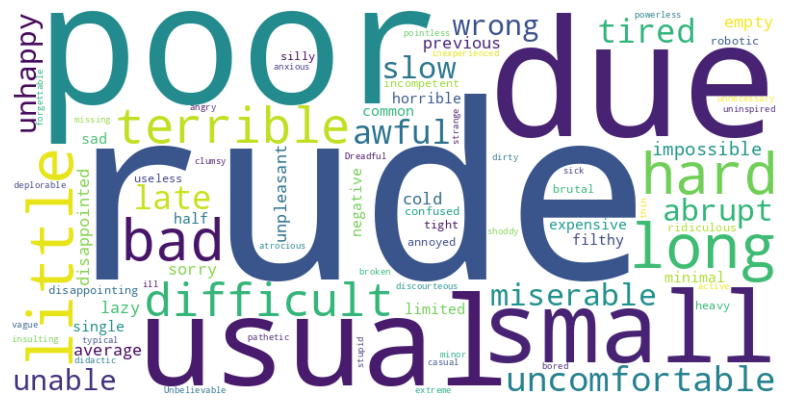

In [7]:
plot_wordcloud(df, "review_text")

## 2.2 Keywords Frequency Analysis

In [8]:
def calculate_keyword_percentage(df, *keyword_groups):
    """
    Calculate the percentage of reviews containing specific keyword groups without modifying the original DataFrame.

    Parameters:
    df (DataFrame): DataFrame with a 'review_text' column.
    *keyword_groups: Variable number of lists, each containing related keywords.

    Returns:
    None
    """
    temp_df = df.copy()
    for keywords in keyword_groups:
        contains_col = temp_df['review_text'].apply(
            lambda review: all(kw.lower() in review.lower() for kw in keywords)
        ).astype(int)
        percentage = (contains_col.mean() * 100).round(2)
        print(f"Percentage of reviews mentioning {', '.join(keywords)}: {percentage}%")


In [9]:
# Calculate percentages for various issues
calculate_keyword_percentage(
    df,
    ['understaff'],
    ['poor'],
    ['rude']
)

Percentage of reviews mentioning understaff: 0.17%
Percentage of reviews mentioning poor: 14.37%
Percentage of reviews mentioning rude: 5.23%


In [10]:
df.to_csv('../data/ground_service_problems.csv')

## 2.3. Topics Grouping

In [11]:
import re

In [12]:
# Optional robust sentiment check (NLTK Vader → keyword fallback)
try:
    from nltk.sentiment import SentimentIntensityAnalyzer  # type: ignore
    _sia = SentimentIntensityAnalyzer()
    def _is_negative(txt: str) -> bool:
        return _sia.polarity_scores(txt)["compound"] < -0.05
except Exception:  # pragma: no cover
    _neg_kw = set("""
        awful bad poor terrible horrible disappointing unacceptable
        nightmare worst pathetic useless disgrace shocking unacceptable
        dissatisfied angry frustrating rude delay delayed dirty broken
    """.split())
    def _is_negative(txt: str) -> bool:               # noqa: E306
        words = set(re.findall(r"[a-z']+", txt.lower()))
        return len(words & _neg_kw) > 0


def group_review_topics(
    df: pd.DataFrame,
    column: str = "review_text",
    topics: dict | None = None,
) -> pd.DataFrame:
    default_topics = {
        "staff_attitude":      ["rude", "attitude", "impolite", "unfriendly", "hostile"],
        "understaffed":        ["understaff", "short staffed", "long queue", "long line", "few staff"],
        "flight_delay":        ["delay", "delayed", "late", "cancelled", "cancellation"],
        "baggage_issue":       ["baggage", "luggage", "lost bag", "missing bag", "delivered late"],
        "seat_comfort":        ["seat", "legroom", "recline", "broken seat", "uncomfortable"],
        "food_beverage":       ["meal", "food", "drink", "beverage", "catering"],
        "cleanliness":         ["dirty", "unclean", "filthy", "messy", "rubbish", "trash"],
        "customer_service":    ["customer service", "complain", "service desk", "support"],
        "communication":       ["announce", "information", "communication", "update"],
        "compensation_refund": ["compensation", "refund", "voucher", "reimburse"],
        "wifi_entertainment":  ["wifi", "internet", "entertainment", "screen", "ife"],
        "ground_service":      ["check-in", "boarding", "gate", "ground staff", "airport staff"],
    }

    topics = topics or default_topics
    regex_map = {k: re.compile("|".join(map(re.escape, v)), re.I) for k, v in topics.items()}

    def _assign(text: str) -> str:
        if not text or not _is_negative(text):
            return "other - non negative"
        for topic, pat in regex_map.items():
            if pat.search(text):
                return topic
        return "other - non negative"

    out = df.copy()
    out["topic"] = out[column].astype(str).apply(_assign)
    return out

In [13]:
df = group_review_topics(df)

In [14]:
df

,review_text,topic
0,The British Airways plane I flew on from Larna...,other - non negative
1,Did this same trip last summer with delays etc...,flight_delay
2,The sad decline of our national flag carrier s...,flight_delay
3,London Heathrow to Dubai in British Airways Fi...,seat_comfort
4,Brussels to Heathrow with British Airways. Lou...,seat_comfort
...,...,...
2995,"I had only 1 bag with me, a carry on trolley. ...",staff_attitude
2996,The employee at Venice Airport checkin was ver...,staff_attitude
2997,Punta Cana Terminal B check in was straightfor...,other - non negative
2998,Could not book online the night before because...,other - non negative


In [15]:
def plot_topic_barchart(df: pd.DataFrame,
                        topic_col: str = "topic",
                        title: str = "Complaint Topics Frequency") -> None:
    """
    Plot a bar chart of topic counts in *df*.

    Parameters
    ----------
    df : DataFrame
        DataFrame containing a column with assigned topics.
    topic_col : str
        Name of the column holding topic labels.
    title : str
        Title for the plot.
    """
    counts = df[topic_col].value_counts().sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(counts.index, counts.values)
    plt.title(title)
    plt.ylabel("Number of Mentions")
    plt.xlabel("Topic")
    plt.xticks(rotation=45, ha="right")

    # annotate counts
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, h, f"{int(h)}",
                 ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

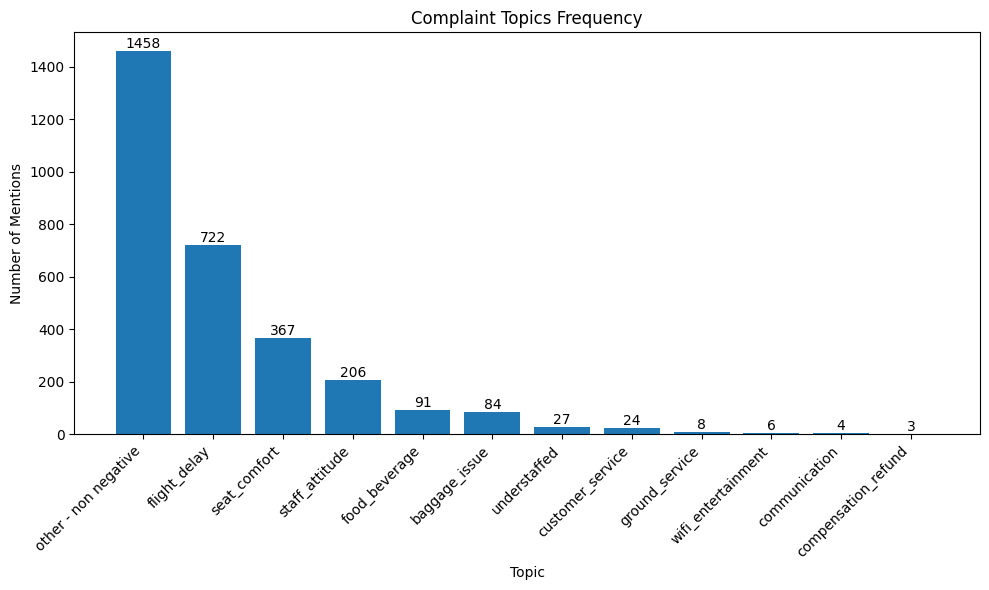

In [16]:
plot_topic_barchart(df)